In [1]:
import numpy as np
from collections import defaultdict
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
from multiprocessing import Pool
from fluid_model import fluid_model#, simulate_index_policy
import json
import codecs
from matplotlib import pyplot as plt
import os

In [2]:
def read_params(file_name):
    params = json.load(open(file_name))
    for key in params:
        if isinstance(params[key], list):
            params[key] = np.array(params[key])
    params["budgets"] = [params["budgets"]] * params["T"]
    return params

In [3]:
file_name = "fu2019.json"
params = read_params(file_name)
params

{'num_actions': 2,
 'num_states': 4,
 'T': 100,
 'gamma': 0.5,
 'r': array([[-1, -1],
        [ 0,  0],
        [ 0,  0],
        [ 1,  1]]),
 'init_occupation': array([0.16666667, 0.33333333, 0.5       , 0.        ]),
 'P1': array([[0.5, 0.5, 0. , 0. ],
        [0. , 0.5, 0.5, 0. ],
        [0. , 0. , 0.5, 0.5],
        [0.5, 0. , 0. , 0.5]]),
 'P0': array([[0.5, 0. , 0. , 0.5],
        [0.5, 0.5, 0. , 0. ],
        [0. , 0.5, 0.5, 0. ],
        [0. , 0. , 0.5, 0.5]]),
 'budgets': [0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0

In [4]:
fluid = fluid_model(params)
fluid.solve()

Using license file /Users/xiangyuzhang/gurobi.lic
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 500 rows, 800 columns and 2784 nonzeros
Model fingerprint: 0xc7af7caa
Coefficient statistics:
  Matrix range     [5e-01, 1e+00]
  Objective range  [2e-30, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 5e-01]
Presolve removed 5 rows and 10 columns
Presolve time: 0.01s
Presolved: 495 rows, 790 columns, 2758 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0107583e+00   4.992855e+02   0.000000e+00      0s
Extra 33 simplex iterations after uncrush
     426    5.5555079e-02   0.000000e+00   0.000000e+00      0s

Solved in 426 iterations and 0.02 seconds
Optimal objective  5.555507872e-02


In [5]:
whittle = fluid.deterministic_simulate_index((2, 1, 0, 3))

print(
f"""
Fluid-balance reward per arm: {fluid.model.objVal}
Whittle reward per arm: {whittle},
Fluid-balance beats Whittle by {(fluid.model.objVal - whittle) / whittle * 100}%.
"""
)


Fluid-balance reward per arm: 0.05555507872379466
Whittle reward per arm: 0.04166666667224994,
Fluid-balance beats Whittle by 33.33218891924085%.



In [6]:
print(
"Check whether this problem is indexable\n",
    fluid.is_feasible([False, False, True, False], 2), "\n",
    fluid.is_feasible([False, True, True, False], 1), "\n",
    fluid.is_feasible([True, True, True, False], 0), "\n",
    fluid.is_feasible([True, True, True, True], 3)
)

Check whether this problem is indexable
 (True, 0.39999999999999997) 
 (True, 0.25) 
 (True, -0.25) 
 (True, -0.4)


In [7]:
model = fluid
def wrapper(args):
    priority, n, m = args
    return model.simulate_index(priority, n, m)

def simulate_index_policy(priority, ns, ms):
    assert(isinstance(priority, tuple))
    assert(isinstance(ns, list))
    assert(isinstance(ms, list))
    assert(len(ns) == len(ms))
    args = [(priority, ns[i], ms[i]) for i in range(len(ns))]
    with Pool(len(ns)) as p:
        res = p.map(wrapper, args)

    return res

def wrapper_fluid_balance(args):
    priority, n, m = args
    return model.simulate_fluid_balance(priority, n, m)

def simulate_fluid_balance(priority, ns, ms):
    assert(isinstance(priority, tuple))
    assert(isinstance(ns, list))
    assert(isinstance(ms, list))
    assert(len(ns) == len(ms))
    args = [(priority, ns[i], ms[i]) for i in range(len(ns))]
    with Pool(len(ns)) as p:
        res = p.map(wrapper_fluid_balance, args)

    return res

In [8]:
def generate_data(trial, priority, file_path, simu):
    ns = [120 * k for k in range(1, trial + 1)]
    ms = [2000] * trial

    if not os.path.exists(file_path):
        res = simu(priority, ns, ms)
        json.dump(np.array(res).tolist(), codecs.open(file_path, 'w', encoding='utf-8'), 
                  separators=(',', ':'), sort_keys=True,indent=4)


In [9]:
generate_data(trial=10, priority=(2, 1, 0, 3), 
              file_path="Fu2019_whittle.json", simu=simulate_index_policy)
generate_data(trial=10, priority=(2, 1, 0, 3), 
              file_path="Fu2019_fluid_balance.json", simu=simulate_fluid_balance)

In [10]:
def plot_performance(name_to_file_path, ns, ms, name_to_colors):
    assert(len(name_to_colors) == len(name_to_file_path))
    res, mean, std_err = {}, {}, {}
    for name in name_to_file_path:
        res[name] = np.array(json.loads(codecs.open(name_to_file_path[name],
                                                    'r', encoding='utf-8').read()))
        mean[name] = np.mean(np.array(res[name]), axis=1) / np.array(ns)

        std_err[name] = np.std(np.array(res[name]) / np.array(ns).reshape(len(ns), 1), 
                         axis=1) / np.sqrt(ms)

    
    fig, ax = plt.subplots()
    for name in name_to_file_path:
        plt.errorbar(ns, mean[name], 2 * std_err[name], 
                     label=name, color=name_to_colors[name], ls='-.')
    plt.plot(ns, [model.model.objVal] * len(ns), "k:^", label="Relaxation Upper Bound", color='r')
    plt.xlabel(ns)
    plt.legend()
    plt.title("Average Reward Per Arm")
    plt.xlabel("Number of Arms")
    plt.grid()
    ax.set_xticks(ns)
    plt.show()
    
    fig, ax = plt.subplots()
    up_bound = model.model.objVal * np.array(ns)
    for name in name_to_file_path:
        assert(np.std(res[name], axis=1).shape == (len(ns), ))
        assert((up_bound - np.mean(np.array(res[name]), axis=1)).shape == (len(ns), ))
    for name in name_to_file_path:
        plt.errorbar(ns, up_bound - np.mean(np.array(res[name]), axis=1),
                     2 * np.std(res[name], axis=1) / np.sqrt(ms), color=name_to_colors[name], 
                     ls='-.', label = name)
    plt.legend()
    plt.title("Optimality Gap")
    plt.xlabel("Number of Arms")
    ax.set_xticks(ns)

    plt.grid()
    plt.show()
    

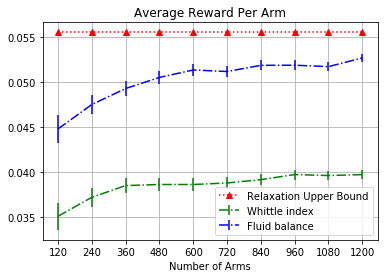

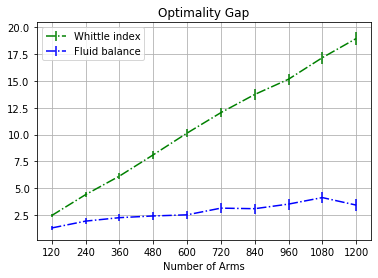

In [11]:
trial = 10
plot_performance({"Whittle index": "Fu2019_whittle.json", "Fluid balance": "Fu2019_fluid_balance.json"},
                 ns = [120 * k for k in range(1, trial + 1)], ms = [2000] * trial, 
                 name_to_colors = {"Whittle index": "green", "Fluid balance": "blue"})